# Transfer learning / fine-tuning



In [6]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [3]:
!pip install tensorflow tensorflow-datasets

In [2]:
import tensorflow_datasets as tfds

# Baixar e preparar o dataset
dataset_name = "cats_vs_dogs"
dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=True)

# Exibir informações do dataset
print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.V9RP5Q_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpybe3__5htfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-

O dataset cats_vs_dogs será carregado utilizando a biblioteca TensorFlow Datasets, obtendo informações sobre o número total de exemplos e configurando os dados no formato (imagem, label).

Então, será definida uma função para preprocessar as imagens, redimensionando-as para 64x64 pixels, normalizando os valores e convertendo as labels em formato one-hot. (Foi necessário configurar em 64x64 por restrição de memória RAM do colab)

Em seguida, o dataset é preprocessado utilizando a função criada, embaralhado com buffer de 1000 exemplos e dividido em conjuntos de treino, validação e teste, seguindo proporções de 70%, 15% e 15%, respectivamente.

Por fim, as dimensões e os tipos dos arrays são exibidos para confirmar o correto processamento dos dados.

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Carregar o dataset e obter informações
dataset_name = "cats_vs_dogs"
dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=True)

# Função para preprocessar as imagens
def preprocess_image(image, label):
    # Redimensionar para 224x224 e normalizar
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    # Converter label para one-hot
    label = tf.one_hot(label, depth=2)
    return image, label

# Aplicar preprocessamento e dividir os dados
dataset = dataset['train'].map(preprocess_image).shuffle(1000)

# Tamanho total do dataset
dataset_size = info.splits['train'].num_examples

# Cálculo das proporções
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

# Divisão do dataset
train_data = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size)

# Organizar em lotes
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Função para converter dataset batched para arrays do NumPy
def dataset_to_numpy_batched(dataset):
    images, labels = [], []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)

# Converter os datasets para arrays
x_train, y_train = dataset_to_numpy_batched(train_data)
x_val, y_val = dataset_to_numpy_batched(val_data)
x_test, y_test = dataset_to_numpy_batched(test_data)

# Verificar os tamanhos e tipos
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"x_train dtype: {x_train.dtype}, y_train dtype: {y_train.dtype}")

x_train shape: (16283, 64, 64, 3), y_train shape: (16283, 2)
x_val shape: (3489, 64, 64, 3), y_val shape: (3489, 2)
x_test shape: (3490, 64, 64, 3), y_test shape: (3490, 2)
x_train dtype: float32, y_train dtype: float32


Exibindo 8 imagens aleatórias

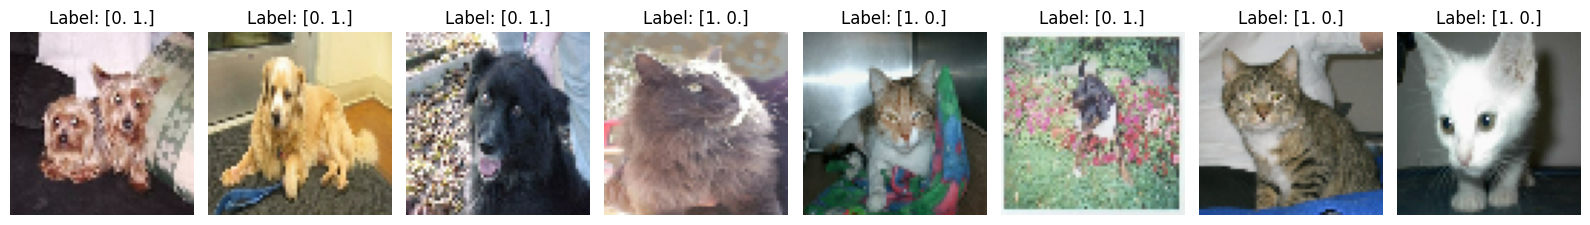

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_random_images(dataset, num_images=8, image_size=(64, 64)):
    images = []
    labels = []

    # Selecionar imagens aleatórias
    for image_batch, label_batch in dataset.shuffle(1000).take(1):  # Pega um lote
        # Redimensiona para 64x64 e pega apenas as primeiras 8 imagens
        image_batch_resized = tf.image.resize(image_batch, image_size)
        for i in range(num_images):
            images.append(image_batch_resized[i].numpy())  # Convertendo para NumPy
            labels.append(label_batch[i].numpy())  # Convertendo para NumPy

    # Organizar as imagens e labels para exibição
    images = np.array(images)
    labels = np.array(labels)

    # Criar uma grade para exibição
    fig, axes = plt.subplots(1, 8, figsize=(16, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Exibir as imagens aleatórias com seus labels
plot_random_images(train_data)


In [12]:
num_classes = len(info.features['label'].names)
num_classes

2

A seguir será criado um modelo de aprendizado transferido baseado no VGG16. O modelo VGG16 será carregado sem a parte totalmente conectada (top layers), mantendo apenas a base convolucional. Uma camada Flatten será adicionada para achatar as saídas da base convolucional, seguida por uma camada densa personalizada com ativação softmax, configurada para classificar as imagens no número de classes definido (num_classes).

Em seguida, será criado um novo modelo conectando a entrada original do VGG16 à nova camada de classificação. As camadas convolucionais do VGG16 terão seus pesos congelados, impedindo ajustes durante o treinamento, enquanto a última camada personalizada permanecerá treinável. Por fim, um resumo do modelo será exibido para validar sua arquitetura.

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import VGG16

# Carregar o modelo VGG16 com input_size 64x64
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Make a reference to VGG's input layer
inp = vgg.input

# Adicionar camadas personalizadas
x = Flatten()(vgg.output)  # Flatten após a parte convolucional
new_classification_layer = Dense(num_classes, activation='softmax')  # Camada de saída com número de classes

# Conectar as camadas
out = new_classification_layer(x)

# Criar o novo modelo
model_new = Model(inp, out)

# Congelar as camadas convolucionais da VGG16
for layer in model_new.layers[:-1]:
    layer.trainable = False

# Garantir que a última camada seja treinável
model_new.layers[-1].trainable = True

# Compilar o modelo
model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumo do modelo
model_new.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,718,786 (56.15 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Será realizado o treinamento do modelo com os dados de treino e validação com um total de 10 épocas (epochs), onde o modelo irá passar pelos dados inteiros 10 vezes.

In [17]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.6759 - loss: 0.5818 - val_accuracy: 0.7945 - val_loss: 0.4367
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7910 - loss: 0.4396 - val_accuracy: 0.8108 - val_loss: 0.4123
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8052 - loss: 0.4191 - val_accuracy: 0.8140 - val_loss: 0.4077
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8243 - loss: 0.3945 - val_accuracy: 0.8126 - val_loss: 0.3999
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8237 - loss: 0.3900 - val_accuracy: 0.8140 - val_loss: 0.4001
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8239 - loss: 0.3879 - val_accuracy: 0.8154 - val_loss: 0.4040
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8292 - loss: 0.3793 - val_accuracy: 0.8180 - val_loss: 0.3953
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8308 - loss: 0.3739 - val_a

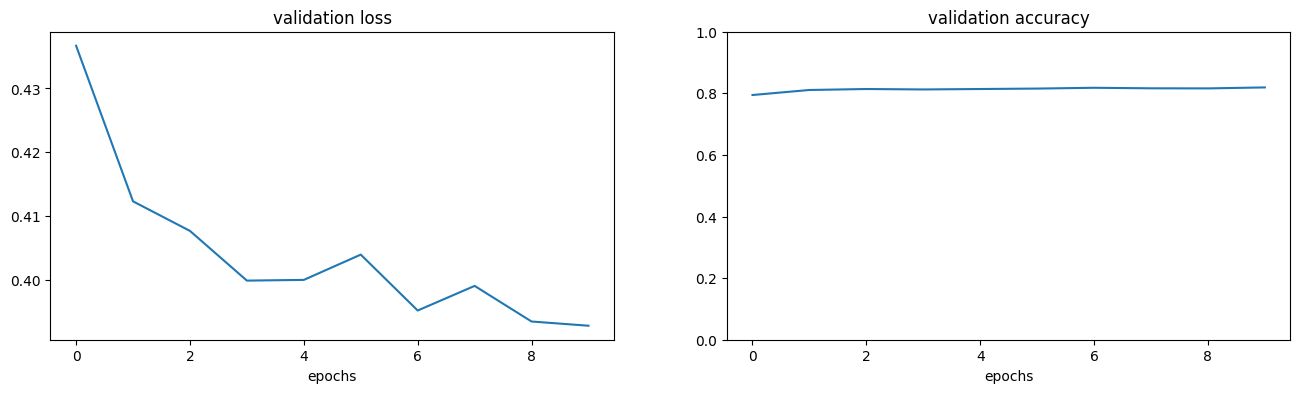

In [19]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [20]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3996671438217163
Test accuracy: 0.8171919584274292


Fazendo previsão com uma imagem externa...

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Função para carregar e pré-processar a imagem
def preprocess_new_image(img_path):
    # Carregar a imagem
    img = image.load_img(img_path, target_size=(64, 64))
    # Converter para array
    img_array = image.img_to_array(img)
    # Expandir a dimensão para ficar no formato (1, 64, 64, 3)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalizar para [0, 1]
    img_array = img_array / 255.0
    return img_array

# Caminho para a nova imagem
img_path = '/content/ellie_joel.jpg'

# Pré-processar a imagem
processed_image = preprocess_new_image(img_path)

# Fazer a previsão
predictions = model_new.predict(processed_image)

# Exibir as probabilidades para cada classe
print(f"Probabilidades para cada classe: {predictions}")

# Obter a classe com a maior probabilidade
predicted_class = np.argmax(predictions, axis=1)
print(f"Classe prevista: {predicted_class[0]}")

# Lista com os nomes das classes, no mesmo ordem das classes do seu modelo
class_names = ['gato', 'cachorro']  # Adapte para as classes do seu problema

# Exibir o nome da classe prevista
predicted_class_name = class_names[predicted_class[0]]
print(f"A imagem pertence à classe: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Probabilidades para cada classe: [[0.7984829  0.20151712]]
Classe prevista: 0
A imagem pertence à classe: gato


Tentativa de aumentar a quantidade de épocas para 40.

In [25]:
history3 = model_new.fit(x_train, y_train,
                         batch_size=32,
                         epochs=40,
                         validation_data=(x_val, y_val))

Epoch 1/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8448 - loss: 0.3528 - val_accuracy: 0.8160 - val_loss: 0.4012
Epoch 2/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8431 - loss: 0.3524 - val_accuracy: 0.8034 - val_loss: 0.4228
Epoch 3/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8456 - loss: 0.3435 - val_accuracy: 0.8065 - val_loss: 0.4158
Epoch 4/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8457 - loss: 0.3440 - val_accuracy: 0.8088 - val_loss: 0.4137
Epoch 5/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8462 - loss: 0.3424 - val_accuracy: 0.8169 - val_loss: 0.4023
Epoch 6/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8438 - loss: 0.3465 - val_accuracy: 0.8140 - val_loss: 0.4047
Epoch 7/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8430 - loss: 0.3460 - val_accuracy: 0.8108 - val_loss: 0.4121
Epoch 8/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8534 - loss: 0.3341 - val

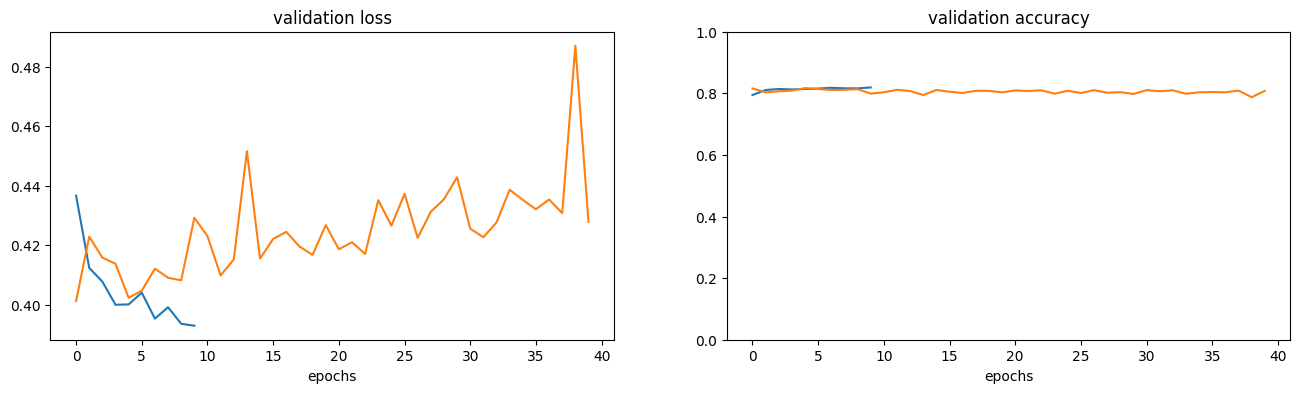

In [26]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.plot(history3.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.plot(history3.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()